# Lab 3: Clustering

The goal of this lab session is to code a clustering algorithm, apply it to data and compare the performance with other techniques.

You have to send the filled notebook named **"L2_familyname1_familyname2.ipynb"** (groups of 2) by email to *violeta.roizman@l2s.centralesupelec.fr* by October 17, 2018. Please put **"AML-L3"** in the subject. 

We begin with the standard imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster # all clustering techniques but hdbscan
import time
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

We will have two to datasets to try the different methods:

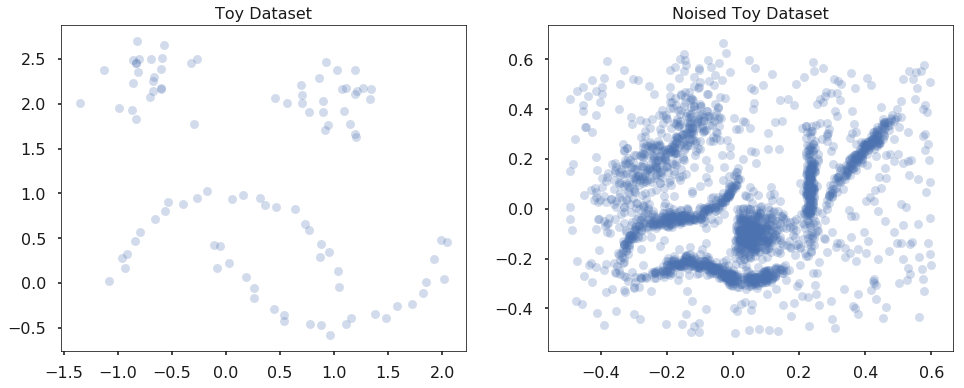

In [2]:
import sklearn.datasets as data
moons, _ = data.make_moons(n_samples=50, noise=0.05)
blobs, _ = data.make_blobs(n_samples=50, centers=[(-0.75,2.25), (1.0, 2.0)], cluster_std=0.25)
test_data_0 = np.vstack([moons, blobs])

test_data_1 = np.load('data/clusterable_data.npy')

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c='b', **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], color='b', **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)

plt.show();

There are a lot of clustering algorithms to choose from `sklearn` library. So what clustering algorithms should you be using? It depends.

## K-means

K-Means is the 'go-to' clustering algorithm for many simply because it is fast, easy to understand, and available everywhere (there's an implementation in almost any statistical or machine learning tool you care to use). However, K-Means has a few problems caused by its simplicity. 

We try the `sklearn` implementation in our toy datasets:

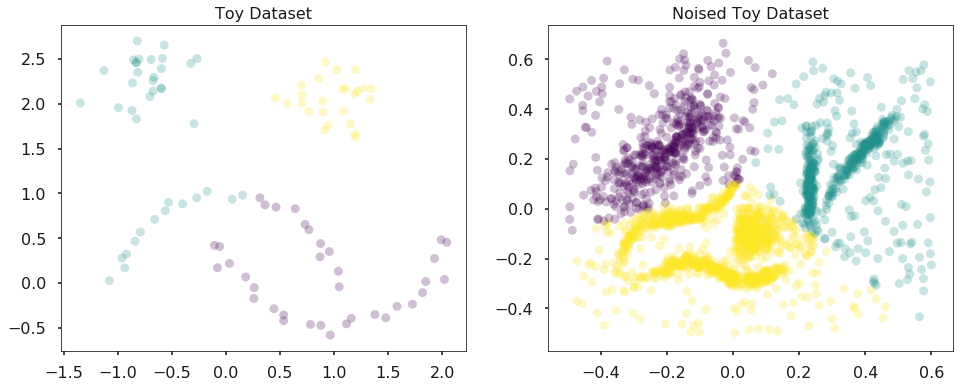

In [3]:
from sklearn.cluster import KMeans
kmeans_0 = KMeans(n_clusters=3, max_iter=200).fit(test_data_0)
kmeans_1 = KMeans(n_clusters=3, max_iter=200).fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=kmeans_0.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=kmeans_1.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show();

## Aglomerative Single Linkage clustering

Agglomerative clustering is a suite of algorithms all based on the same idea. The fundamental idea is that you start with each point in it's own cluster and then, for each cluster, use some criterion to choose another cluster to merge with. Do this repeatedly until you have only one cluster and you get a hierarchy, or binary tree, of clusters branching down to the last layer which has a leaf for each point in the dataset. The most basic version of this, single linkage, chooses the closest cluster to merge, and hence the tree can be ranked by distance as to when clusters merged/split.

**Code your own Aglomerative Single Linkage clustering algorithm**!:

- Fill in the class 
- During the process, keep track of the cluster merges by saving a (num_samples-1,4) np.array being a linkage matrix in scypy format (to use their function to plot dendrogram: `scipy.cluster.hierarchy.dendrogram`). check documentation.

In [4]:
class my_SingleLinkageAglomerativeClustering():
    
    def __init__(self, metric="euclidean", n_clusters=3):
        '''
        Attributes:
        
        metric_: {"euclidean","precomputed"}
            the distance to be used
            if precomputed then X is distance matrix
        n_clusters: integer
            number of clusters to return 
        linkage_matrix_: (n-1, 4) np.array
            in the same format as linkage  
        labels_: integer np.array
            label assigment
        hierarchy_: list of np.array
            each array corresponds to label assigment
            at each level (number of clusters)
            hierarchy_[0]=np.array(list(range(n)))
        '''
        self.metric_ = metric
        self.n_clusters_ = n_clusters
        self.linkage_matrix_ = None
        self.labels_ = None
        self.hierarchy_ = None
        self.distance_matrix_ = None
        
    def __init_clustering(self, X):
        """
        Initialize distance_matrix, linkage_matrix, labels and hierarchy attributes
        """
        if self.metric_ == "euclidean":
            # Compute distance between each initial cluser i.e. observation
            distance_scipy_output = distance.pdist(X, metric=self.metric_)
            # Transform distance list to symmetric matrix with null diagonal
            self.distance_matrix_ = distance.squareform(distance_scipy_output)
        elif self.metric_ == "precomputed":
            self.distance_matrix_ = X
        else:
            raise NotImplementedError
        
        # initialize the linkage records as an empty matrix
        self.linkage_matrix_ = np.zeros((len(X)-1, 4))
        
        # initialize the hierarchy records with cluster label for each observation (i.e themselves)
        self.hierarchy_ = [np.arange(len(X))]
        
        # initialize labels record as last item in hierarchy records
        self.labels_ = self.hierarchy_[-1]
                
    
    def __get_closest_clusters(self):
        # Get the closest 2 clusters
        min_distance = np.min(self.distance_matrix_[self.distance_matrix_!=0])
        label_i, label_j = np.where(self.distance_matrix_ == min_distance)[0]
        return label_i, label_j
    
    
    def __get_population_cluster(self, label):
        # Count number of observation belonging to cluster label
        population = len(np.where(self.labels_==label)[0])
        return population
    
    def __merge_clusters(self, iteration, i, j):
        # Count number of observation belonging to merged cluster
        population_i = self.__get_population_cluster(i)
        population_j = self.__get_population_cluster(j)
        merged_population = population_i + population_j
        
        # Generate new label for merged cluster
        new_label = np.max(self.labels_) + 1
        
        # Add merging operation to linkage records
        dist_i_j = self.distance_matrix_[i,j]
        self.linkage_matrix_[iteration] = np.array([i, j, dist_i_j, merged_population])
        
        # Update hierarchy and labels record
        new_hierarchy = np.copy(self.hierarchy_[-1])
        new_hierarchy[new_hierarchy==i] = new_label
        new_hierarchy[new_hierarchy==j] = new_label
        self.hierarchy_ += [new_hierarchy]
        self.labels_ = np.copy(new_hierarchy)
        
        # Update distance matrix with new cluster
        n = len(self.distance_matrix_)
        new_distances = np.array([min(self.distance_matrix_[k, i], self.distance_matrix_[k, j]) for k in range(n)])
        self.distance_matrix_ = np.hstack([self.distance_matrix_, new_distances.reshape(n,1)])
        self.distance_matrix_ = np.vstack([self.distance_matrix_, np.concatenate([new_distances, np.zeros(1)])])
        self.distance_matrix_[:,i] = 0
        self.distance_matrix_[:,j] = 0
        self.distance_matrix_[i,:] = 0
        self.distance_matrix_[j,:] = 0
        
        
        
    def fit(self, X):
        """ Create a hierarchy of clusters
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self: my_SingleLinkageAglomerativeClustering
            to have access to labels_
        """ 
        self.__init_clustering(X)
        nr_clusters = len(np.unique(self.labels_))
        
        iteration = 0
        while nr_clusters > 1:
            label_i, label_j = self.__get_closest_clusters()
            self.__merge_clusters(iteration, label_i, label_j)
            iteration += 1
            nr_clusters = len(np.unique(self.labels_))
    
    def plot_dendrogram(self, figsize=(12,8), **kwargs):
        '''Use self.linkage_matrix_ in `scipy.cluster.hierarchy.dendrogram` 
        to plot the dendrogram of the hierarchical structure
        '''
        plt.figure(figsize=(12,8))
        return dendrogram(self.linkage_matrix_, **kwargs)

### Applying to our datasets

In [5]:
from scipy.spatial import distance 
from scipy.cluster.hierarchy import dendrogram

- __Test on__ `test_data_0`

In [6]:
%%time
clstr1 = my_SingleLinkageAglomerativeClustering()
clstr1.fit(test_data_0)

CPU times: user 47.6 ms, sys: 2.61 ms, total: 50.2 ms
Wall time: 49 ms


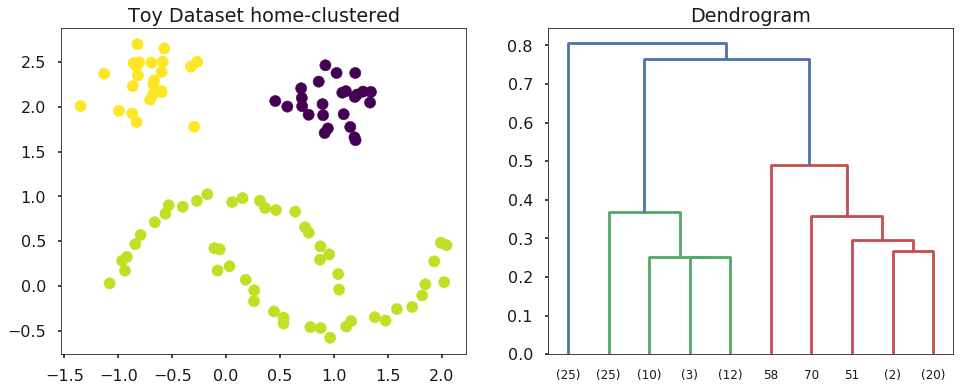

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=clstr1.hierarchy_[-3])
ax[0].set_title('Toy Dataset home-clustered')

clstr1.plot_dendrogram(truncate_mode = "lastp", p=10, ax=ax[1])
ax[1].set_title('Dendrogram')
plt.show()

Clustering is very satisfying on the Toy Dataset as clusters are actually already very separate and distinct

- __Test on__ `test_data_1`

__Warning__ : large running time

In [8]:
%%time
clstr2 = my_SingleLinkageAglomerativeClustering()
clstr2.fit(test_data_1)

CPU times: user 5min 8s, sys: 3min 58s, total: 9min 7s
Wall time: 9min 13s


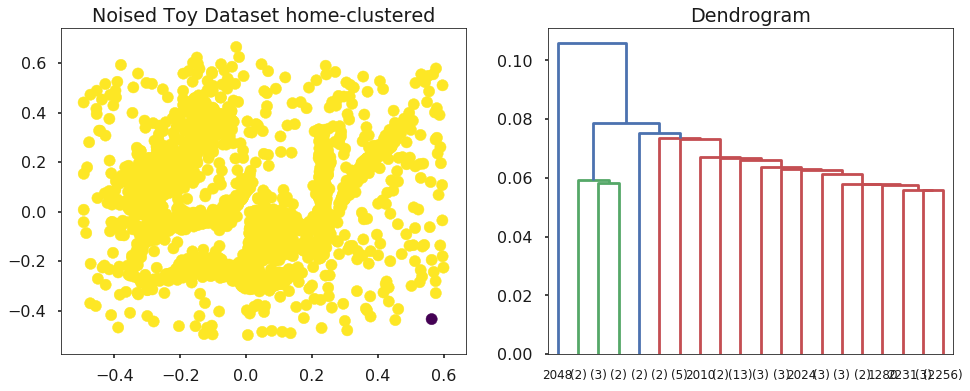

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_1.T[0], test_data_1.T[1], c=clstr2.hierarchy_[-3])
ax[0].set_title('Noised Toy Dataset home-clustered')

clstr2.plot_dendrogram(truncate_mode = "lastp", p=20, ax=ax[1])
ax[1].set_title('Dendrogram')
plt.show()

Adding noise perturbates the algorithm as potential clusters are in touch, which is not good clustering material for an single linkage agglomerative clustering algorithm. Indeed, using minimum distance interclusters makes it sensitive to noise and clusters tend to be "chained" by noise. Here, a density based algorithm would definitely enhance the performances.

Plus, computational time gets very large. To reach reasonnable computing time, we would consider for example parallelizing jobs. Also, as the number of samples exceeds a thousand rows, out clusters distance matrix starts getting very large : less memory consuming solution should be considered

### `sklearn` linkage methods

Try the different linkage methods implemented in `sklearn`  and comment

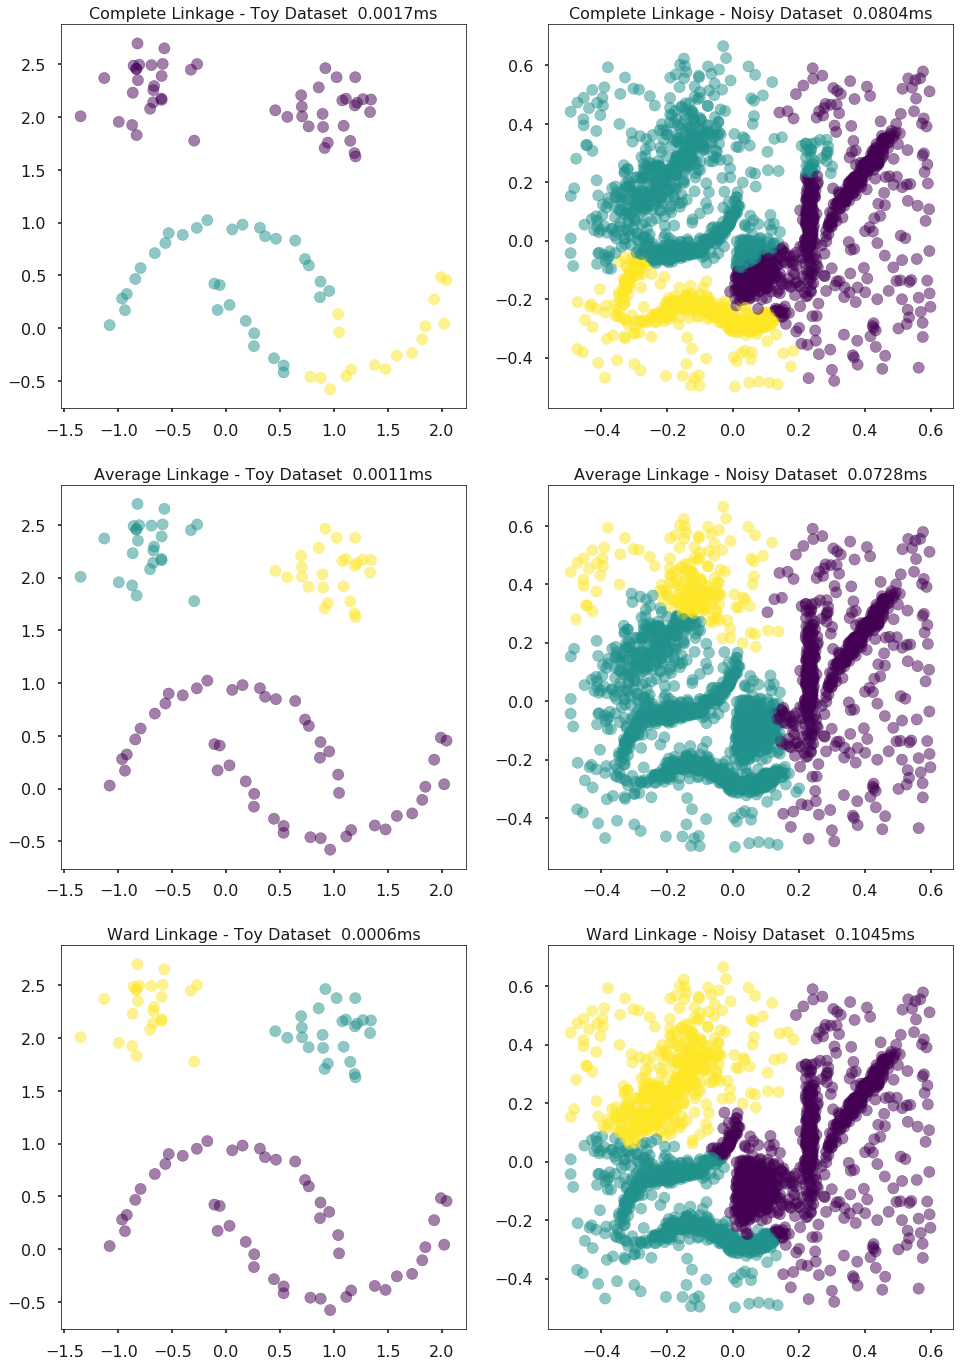

In [10]:
from sklearn.cluster import AgglomerativeClustering

linkage_methods = {'Ward Linkage':'ward',
                   'Complete Linkage':'complete',
                   'Average Linkage':'average'}

datasets = {'Toy Dataset':test_data_0, 
            'Noisy Dataset':test_data_1}

fig, ax = plt.subplots(3, 2, figsize=(16, 24))

for i, l_key in enumerate(linkage_methods.keys()):
    for j, d_key in enumerate(datasets.keys()):
        skclust = AgglomerativeClustering(n_clusters=3, linkage=linkage_methods[l_key])
        start_time = time.time()
        skclust.fit(datasets[d_key])
        duration = str(round(time.time()-start_time,4)) + "ms"
        ax[i, j].scatter(datasets[d_key].T[0], datasets[d_key].T[1], c=skclust.labels_, alpha=0.5)
        ax[i, j].set_title(l_key + " - " + d_key + "  " + duration, size=16)
        
plt.show()

- __Complete Linkage__

> The complete linkage solves the chaining chaining problem we are facing with the single linkage. Still, the streched-out shape of the Toy Datset clusters isn't suitable for a complete linkage algorithm. Indeed, if we use the maximum distance between clusters, some samples belonging to the lower half-circle seem actually closer to the upper one. On the other hand, maximum distance works fine with more "circle-shaped" clusters

- __Average Linkage__

> The average distance linkage delivers a satisfying clustering for the Toy Dataset, solving the chaining problem. Lacks though of density-driven clustering which we can notive in the noised dataset : averaging separate clusters sure gives robustness but can also induce bias if those are very separate

- __Ward Linkage__

> Definitely the most satisfying clustering, merging clusters minimizing the MSE w.r.t centroids brings robustness and lowers outliers impact. Still, runs slower than other linkage methods.

Also, as expected, `sklearn` implementations are more efficient than our.

## DBSCAN

DBSCAN is a density based algorithm -- it assumes clusters for dense regions. It is also the first actual clustering algorithm we've looked at: it doesn't require that every point be assigned to a cluster and hence doesn't partition the data, but instead extracts the 'dense' clusters and leaves sparse background classified as 'noise'. In practice DBSCAN is related to agglomerative clustering. As a first step DBSCAN transforms the space according to the density of the data: points in dense regions are left alone, while points in sparse regions are moved further away. Applying single linkage clustering to the transformed space results in a dendrogram, which we cut according to a distance parameter (called epsilon or `eps` in many implementations) to get clusters. Importantly any singleton clusters at that cut level are deemed to be 'noise' and left unclustered. 

Apply it to the test_data, how do you tune the parameters?

### DBSCAN Parameters tuning

To tune the `eps` and `min_samples` parameters of our DBSCAN, we perform a grid search.

We will here focus on the second dataset which is the relevant one to try density-based algorithms.

In [11]:
eps_grid = [0.01, 0.02, 0.04, 0.08, 0.2, 0.4]
min_samples_grid = [2, 5, 10, 25, 50]

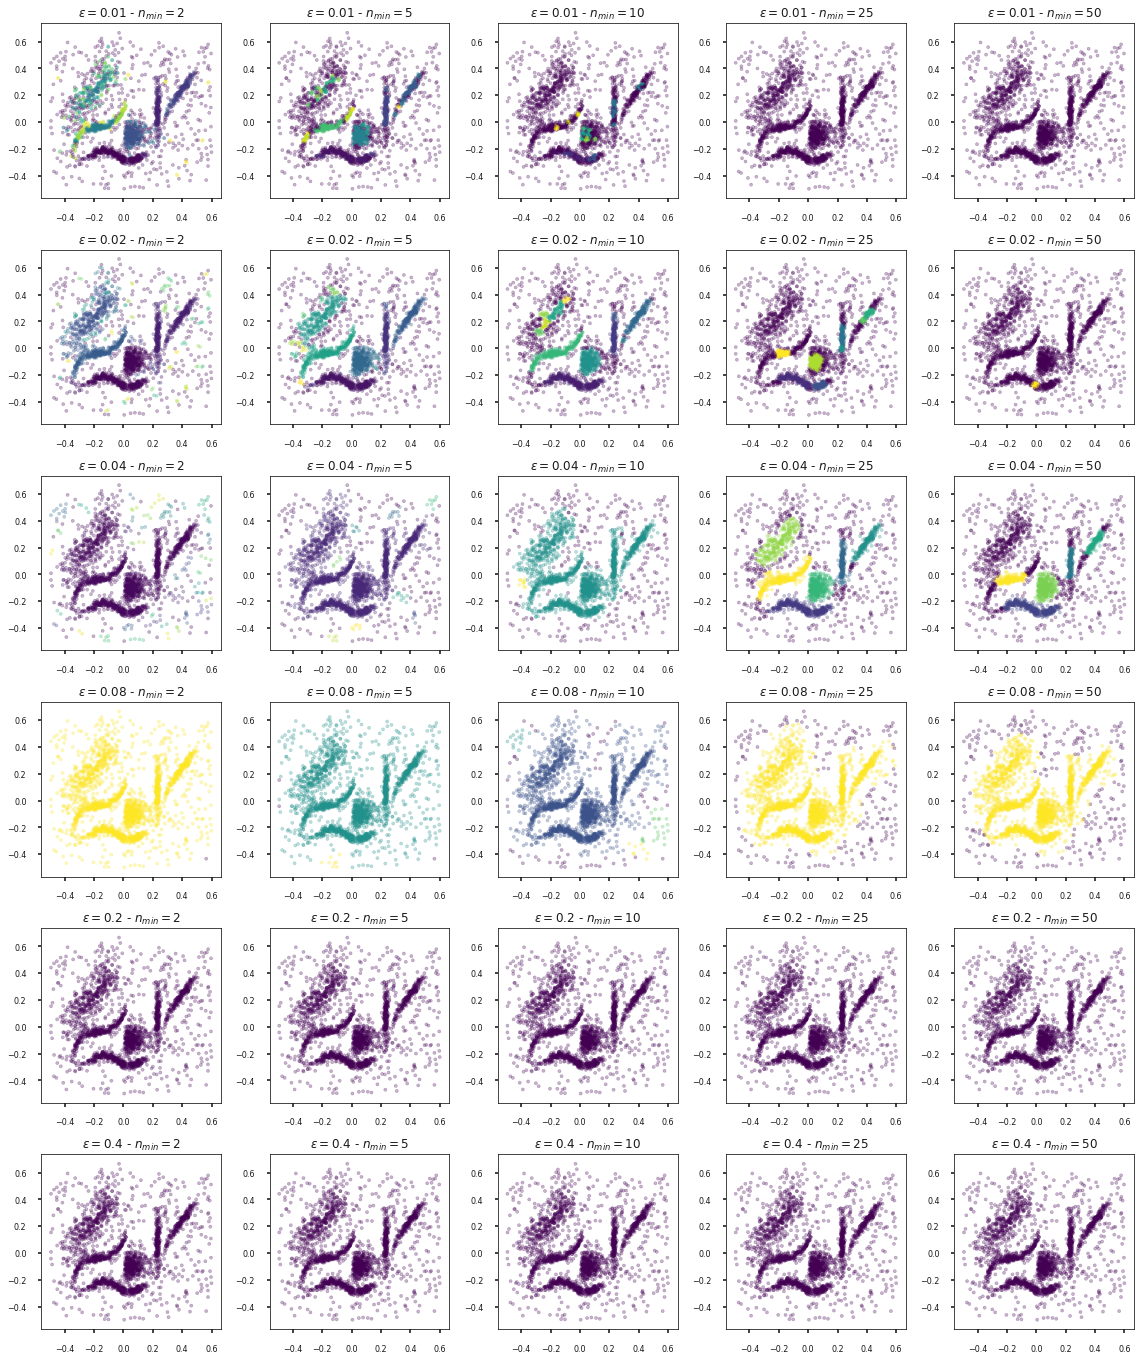

In [12]:
n, p = len(eps_grid), len(min_samples_grid)
fig, ax = plt.subplots(n, p, figsize=(16, 16*n//p))

for i, eps in enumerate(eps_grid):
    for j, min_samples in enumerate(min_samples_grid):
        dbscan = cluster.DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        dbscan.fit(test_data_1)
        ax[i][j].scatter(test_data_1.T[0], test_data_1.T[1], c=dbscan.labels_, alpha=0.3, s=10)
        ax[i][j].set_title(r"$\varepsilon =$" + str(eps) + r" - $n_{min}=$" + str(min_samples), size=12)
        ax[i][j].tick_params(axis='both', labelsize=8)
plt.tight_layout()

"Visually", the best set of parameters would be :
> `eps=0.04` and `min_samples=25`

## HDBSCAN

HDBSCAN is a recent algorithm developed by some of the same people who write the original DBSCAN paper. Their goal was to allow varying density clusters. The algorithm starts off much the same as DBSCAN: we transform the space according to density, exactly as DBSCAN does, and perform single linkage clustering on the transformed space. Instead of taking an epsilon value as a cut level for the dendrogram however, a different approach is taken: the dendrogram is condensed by viewing splits that result in a small number of points splitting off as points 'falling out of a cluster'. This results in a smaller tree with fewer clusters that 'lose points'. That tree can then be used to select the most stable or persistent clusters. This process allows the tree to be cut at varying height, picking our varying density clusters based on cluster stability.

In [14]:
import hdbscan

In [15]:
range_min_cluster_size = [2, 5, 10, 25, 50, 75]

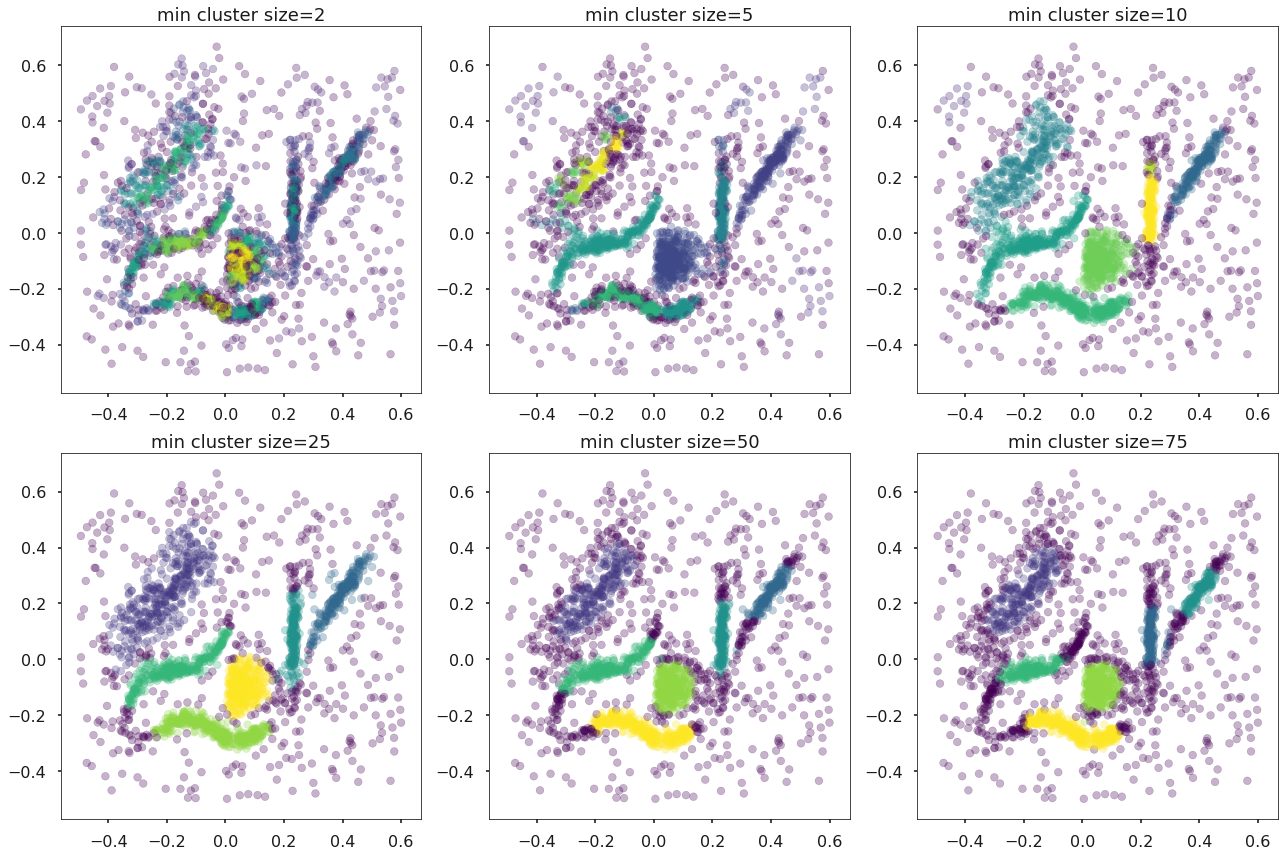

In [16]:
n = len(range_min_cluster_size)//3

fig, ax = plt.subplots(n,3, figsize=(18, 6*n))

for i, min_cluster_size in enumerate(range_min_cluster_size):
    clstr_hdbscan = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
    clstr_hdbscan.fit(test_data_1)
    ax[i//3][i%3].scatter(test_data_1.T[0], test_data_1.T[1], c=clstr_hdbscan.labels_, alpha=0.3, s=60)
    ax[i//3][i%3].set_title("min cluster size=" + str(min_cluster_size), size=18)
plt.tight_layout()

## Apply the algorithms to the following images and comment the results

### NASA Curiosity Picture

- Look at following NASA photo taken by a robot in mars:


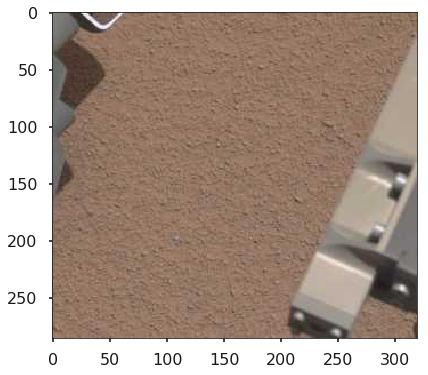

In [17]:
from PIL import Image

Im_1  = Image.open('data/im_nasa_reduced.jpg')

fig = plt.figure(figsize=(8, 6))
plt.imshow(Im_1)
plt.show()

- Transform the image to an intensity (I) and saturation (S) representation, it helps to distinguish bright and textures.

$$I=\frac{R+G+B}{3}$$
$$S=1-I\times min(R, G, B)$$

We first preprocess the image to sharpen it

In [18]:
from scipy import ndimage

def sharpen_img(img, alpha=15):
    blurred_img = ndimage.gaussian_filter(img, 3)
    filter_blurred_img = ndimage.gaussian_filter(blurred_img, 1)
    sharpened_img = blurred_img + alpha*(blurred_img - filter_blurred_img) 
    return sharpened_img

Text(0.5,1,u'Sharpened image')

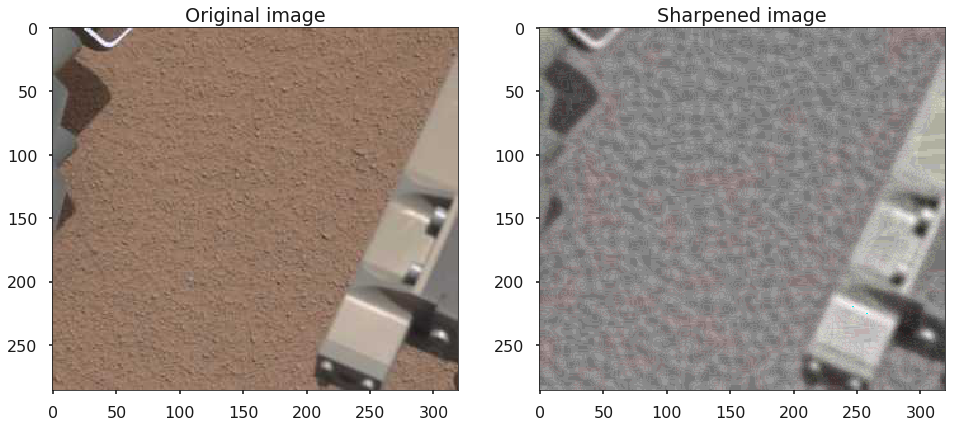

In [19]:
sharpened_img = sharpen_img(Im_1)

fig, ax = plt.subplots(1, 2, figsize=(16,8))
ax[0].imshow(Im_1)
ax[0].set_title("Original image")
ax[1].imshow(sharpened_img)
ax[1].set_title("Sharpened image")

Then extract intensity and saturation out of it

In [20]:
def getIS(img):
    (height, width) = img.getbbox()[2:]
    I = np.zeros((width, height))
    S = np.zeros((width, height))

    for i in range(width):
        for j in range(height):
            pixel = img.getpixel((j,i))
            intensity = sum(pixel)/3.
            I[i,j] = intensity
            S[i,j] = 1-intensity*min(pixel)
    IS = np.zeros((height * width, 2))
    IS[:, 0] = I.flatten()
    IS[:, 1] = S.flatten()
    return I, S, IS

I, S, IS = getIS(Im_1)
sharpened_I, sharpened_S, sharpened_IS = getIS(Image.fromarray(sharpened_img))

Text(0.5,1,u'Sharpened Saturation representation')

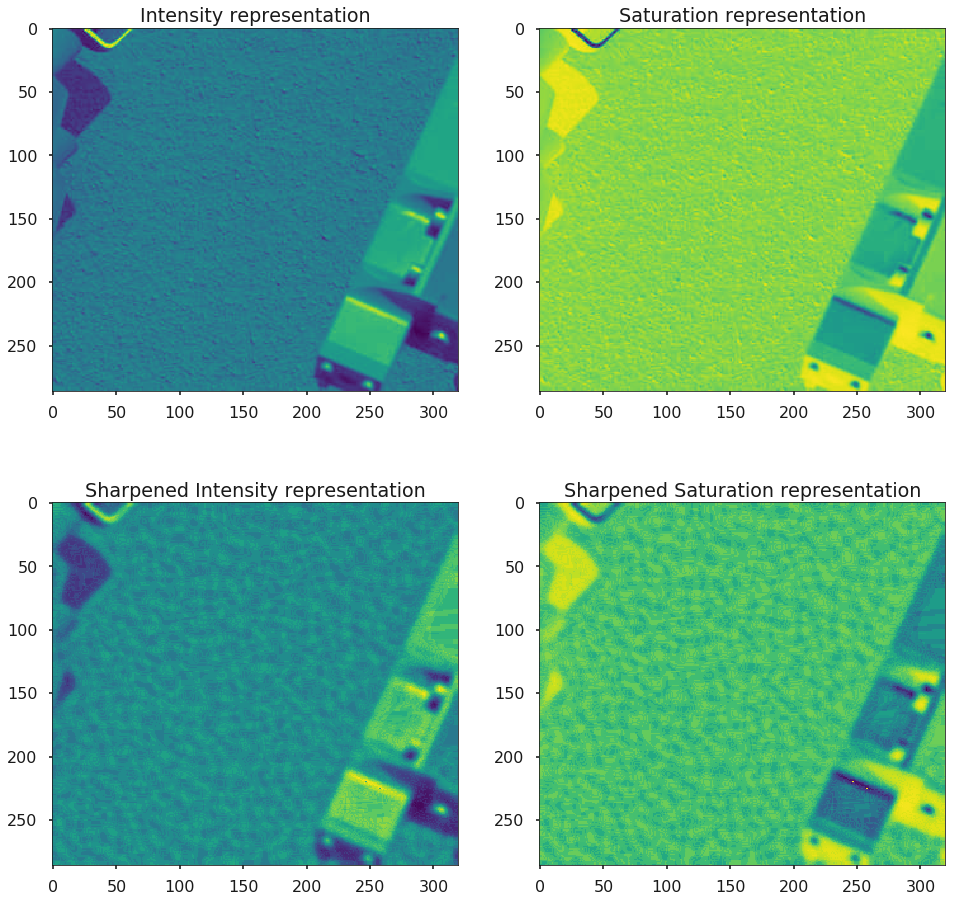

In [21]:
fig, ax = plt.subplots(2,2, figsize=(16, 16))
ax[0][0].imshow(I)
ax[0][0].set_title("Intensity representation")
ax[0][1].imshow(S)
ax[0][1].set_title("Saturation representation")
ax[1][0].imshow(sharpened_I)
ax[1][0].set_title("Sharpened Intensity representation")
ax[1][1].imshow(sharpened_S)
ax[1][1].set_title("Sharpened Saturation representation")

- Apply the seen algorithms to segment the image, comment the results and check if you find something on mars' surface. Be careful with hdbscan and memory errors for some parameters choice (use algorithm='boruvka_kdtree').

In [22]:
import matplotlib.cm as cm

def plot_img(ax, labels, width, height):
    if len(labels) != width * height:
        raise RuntimeError("Dimensions do not match with the labels vector length.")
    grid = labels.reshape((height, width))
    ax.imshow(grid, extent=(0, width, 0, height), cmap=cm.Dark2)

#### DBSCAN

In [23]:
dbscan_clstr = cluster.DBSCAN(eps=0.6)
dbscan_clstr.fit(IS)

dbscan_sharpened_clstr = cluster.DBSCAN(eps=0.6)
dbscan_sharpened_clstr.fit(sharpened_IS)

DBSCAN(algorithm='auto', eps=0.6, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=1, p=None)

Text(0.5,1,u'DBSCAN on sharpened')

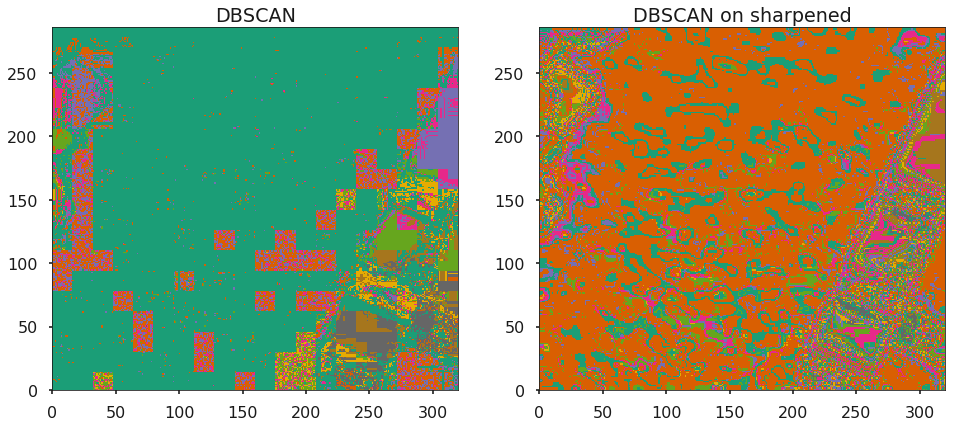

In [24]:
(width, height) = Im_1.getbbox()[2:]

fig, ax = plt.subplots(1, 2, figsize=(16,8))
plot_img(ax[0], dbscan_clstr.labels_, width, height)
ax[0].set_title("DBSCAN")
plot_img(ax[1], dbscan_sharpened_clstr.labels_, width, height)
ax[1].set_title("DBSCAN on sharpened")

#### HDBSCAN

In [25]:
hdbscan_clstr = hdbscan.HDBSCAN()
hdbscan_clstr.fit(IS)

hdbscan_clstr_sharpen = hdbscan.HDBSCAN()
hdbscan_clstr_sharpen.fit(sharpened_IS)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

Text(0.5,1,u'HDBSCAN on sharpened')

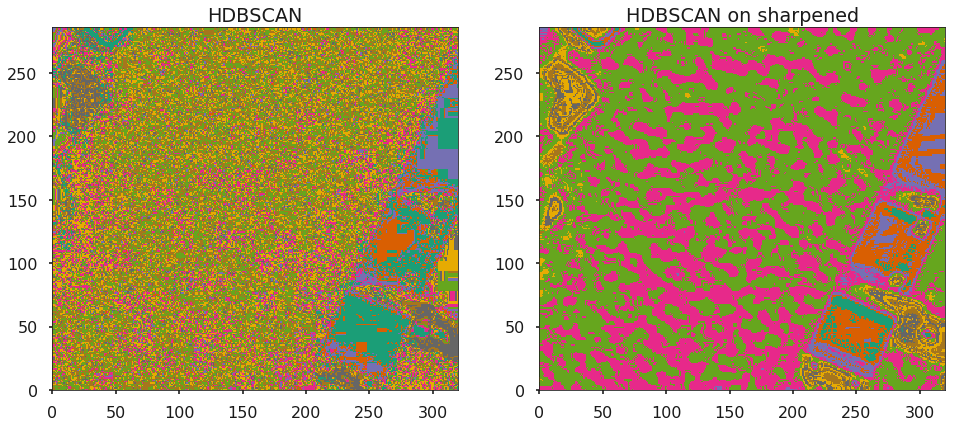

In [26]:
(width, height) = Im_1.getbbox()[2:]

fig, ax = plt.subplots(1, 2, figsize=(16,8))
plot_img(ax[0], hdbscan_clstr.labels_, width, height)
ax[0].set_title("HDBSCAN")
plot_img(ax[1], hdbscan_clstr_sharpen.labels_, width, height)
ax[1].set_title("HDBSCAN on sharpened")

### Color compression

One interesting application of clustering is in color compression within images. 
For example, imagine you have an image with millions of colors.
In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

Get a simplified 10-colored version of the following image by applying k-means. Plot both images.

/Users/dieze/anaconda/envs/ptc_env/lib/python2.7/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
/Users/dieze/anaconda/envs/ptc_env/lib/python2.7/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]


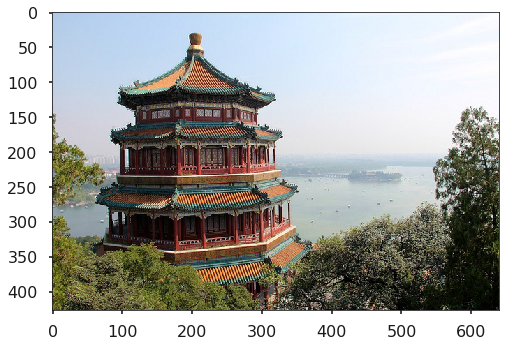

In [27]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")

fig = plt.figure(figsize=(8, 6))
plt.imshow(china);

In [28]:
height, width = china.shape[:2]

china_colors = np.zeros((height*width, 3))
for i in range(3):
    china_colors[:,i] = china[:,:,i].reshape(height*width)

In [29]:
%%time
kmeans_china = cluster.KMeans(n_clusters=10, max_iter=200).fit(china_colors)

CPU times: user 10.4 s, sys: 3.25 s, total: 13.6 s
Wall time: 13.5 s


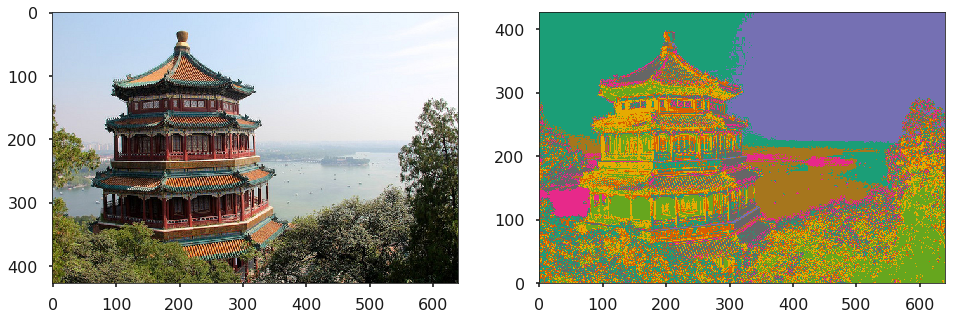

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))
ax[0].imshow(china)
plot_img(ax[1], kmeans_china.labels_, width, height)